In [10]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [11]:
# datasets
class CustomImageDataset(Dataset):
    """Кастомный датасет для работы с папками классов"""

    def __init__(self, root_dir, transform=None, target_size=(224, 224)):
        """
        Args:
            root_dir (str): Путь к папке с классами
            transform: Аугментации для изображений
            target_size (tuple): Размер для ресайза изображений
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        # Получаем список классов (папок)
        self.classes = sorted([d for d in os.listdir(root_dir)
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Собираем все пути к изображениям
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')

        # Ресайзим изображение
        image = image.resize(self.target_size, Image.Resampling.LANCZOS)

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_names(self):
        """Возвращает список имен классов"""
        return self.classes

In [12]:
#utils
def show_images(images, labels=None, nrow=8, title=None, size=128):
    """Визуализирует батч изображений."""
    images = images[:nrow]

    # Увеличиваем изображения до 128x128 для лучшей видимости
    resize_transform = transforms.Resize((size, size), antialias=True)
    images_resized = [resize_transform(img) for img in images]

    # Создаем сетку изображений
    fig, axes = plt.subplots(1, nrow, figsize=(nrow*2, 2))
    if nrow == 1:
        axes = [axes]

    for i, img in enumerate(images_resized):
        img_np = img.numpy().transpose(1, 2, 0)
        # Нормализуем для отображения
        img_np = np.clip(img_np, 0, 1)
        axes[i].imshow(img_np)
        axes[i].axis('off')
        if labels is not None:
            axes[i].set_title(f'Label: {labels[i]}')

    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def show_augmentations(original_img, augmented_imgs, titles):
    """Визуализирует оригинальное изображение и несколько аугментаций."""
    n_augs = len(augmented_imgs)
    fig, axes = plt.subplots(1, n_augs + 1, figsize=((n_augs + 1) * 2, 2))

    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)

    orig_np = np.array(orig_resized)
    axes[0].imshow(orig_np)
    axes[0].set_title("Оригинал")
    axes[0].axis('off')

    for i, (aug_img, title) in enumerate(zip(augmented_imgs, titles)):
        aug_resized = resize_transform(aug_img)
        aug_np = aug_resized.numpy().transpose(1, 2, 0)
        aug_np = np.clip(aug_np, 0, 1)
        axes[i + 1].imshow(aug_np)
        axes[i + 1].set_title(title)
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
#augmentations
class AddGaussianNoise:
    """Добавляет гауссов шум к изображению."""
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

class RandomErasingCustom:
    """Случайно затирает прямоугольную область изображения."""
    def __init__(self, p=0.5, scale=(0.02, 0.2)):
        self.p = p
        self.scale = scale
    def __call__(self, img):
        if np.random.random() > self.p:
            return img
        c, h, w = img.shape
        area = h * w
        erase_area = np.random.uniform(*self.scale) * area
        erase_w = int(np.sqrt(erase_area))
        erase_h = int(erase_area // erase_w)
        x = np.random.randint(0, w - erase_w)
        y = np.random.randint(0, h - erase_h)
        img[:, y:y+erase_h, x:x+erase_w] = 0
        return img

class CutOut:
    """Вырезает случайную прямоугольную область из изображения."""
    def __init__(self, p=0.5, size=(16, 16)):
        self.p = p
        self.size = size
    def __call__(self, img):
        if np.random.random() > self.p:
            return img
        c, h, w = img.shape
        cut_h, cut_w = self.size
        x = np.random.randint(0, w - cut_w)
        y = np.random.randint(0, h - cut_h)
        img[:, y:y+cut_h, x:x+cut_w] = 0
        return img

class Solarize:
    """Инвертирует пиксели выше порога."""
    def __init__(self, threshold=128):
        self.threshold = threshold
    def __call__(self, img):
        img_np = img.numpy()
        mask = img_np > self.threshold / 255.0
        img_np[mask] = 1.0 - img_np[mask]
        return torch.from_numpy(img_np)

class Posterize:
    """Уменьшает количество бит на канал."""
    def __init__(self, bits=4):
        self.bits = bits
    def __call__(self, img):
        img_np = img.numpy()
        factor = 2 ** (8 - self.bits)
        img_np = (img_np * 255).astype(np.uint8)
        img_np = (img_np // factor) * factor
        return torch.from_numpy(img_np.astype(np.float32) / 255.0)

class AutoContrast:
    """Автоматически улучшает контраст изображения."""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if np.random.random() > self.p:
            return img
        img_np = img.numpy().transpose(1, 2, 0)
        img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
        img_pil = ImageOps.autocontrast(img_pil)
        img_np = np.array(img_pil).astype(np.float32) / 255.0
        return torch.from_numpy(img_np.transpose(2, 0, 1))

class ElasticTransform:
    """Эластичная деформация изображения."""
    def __init__(self, p=0.5, alpha=1, sigma=50):
        self.p = p
        self.alpha = alpha
        self.sigma = sigma
    def __call__(self, img):
        if np.random.random() > self.p:
            return img
        img_np = img.numpy().transpose(1, 2, 0)
        h, w = img_np.shape[:2]

        dx = np.random.randn(h, w) * self.alpha
        dy = np.random.randn(h, w) * self.alpha

        dx = cv2.GaussianBlur(dx, (0, 0), self.sigma)
        dy = cv2.GaussianBlur(dy, (0, 0), self.sigma)

        x, y = np.meshgrid(np.arange(w), np.arange(h))
        x = x + dx
        y = y + dy
        x = np.clip(x, 0, w - 1)
        y = np.clip(y, 0, h - 1)

        img_deformed = cv2.remap(img_np, x.astype(np.float32), y.astype(np.float32),
                                cv2.INTER_LINEAR)
        return torch.from_numpy(img_deformed.transpose(2, 0, 1))

class MixUp:
    """Смешивает два изображения."""
    def __init__(self, p=0.5, alpha=0.2):
        self.p = p
        self.alpha = alpha
    def __call__(self, img1, img2):
        if np.random.random() > self.p:
            return img1
        lam = np.random.beta(self.alpha, self.alpha)
        return lam * img1 + (1 - lam) * img2

In [14]:
# dirs
results_dir = 'drive/MyDrive/PyTorch5/result'
train_dir = 'drive/MyDrive/PyTorch5/data/train'
test_dir = 'drive/MyDrive/PyTorch5/data/test'

# Задание 1: Стандартные аугментации torchvision

In [20]:
dataset = CustomImageDataset(train_dir, transform=None, target_size=(224, 224))
class_names = dataset.get_class_names()

standard_augs = [
        ('RandomHorizontalFlip', transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=1.0)])),
        ('RandomCrop', transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(200, padding=20)])),
        ('ColorJitter', transforms.Compose([transforms.ToTensor(), transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)])),
        ('RandomRotation', transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(degrees=30)])),
        ('RandomGrayscale', transforms.Compose([transforms.ToTensor(), transforms.RandomGrayscale(p=1.0)]))
    ]

combined_aug = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(200, padding=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(degrees=30),
        transforms.RandomGrayscale(p=0.2)
    ])

Оригинальное изображение, класс: Гароу


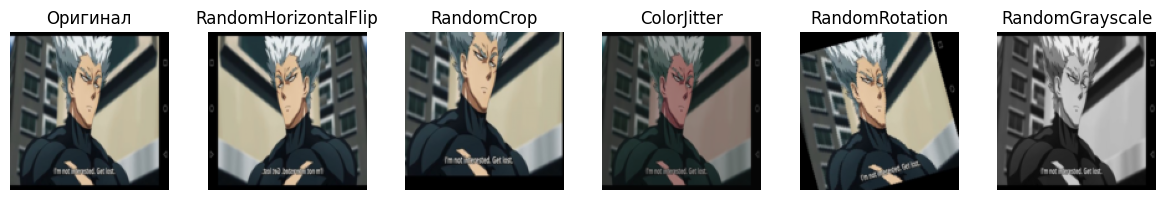

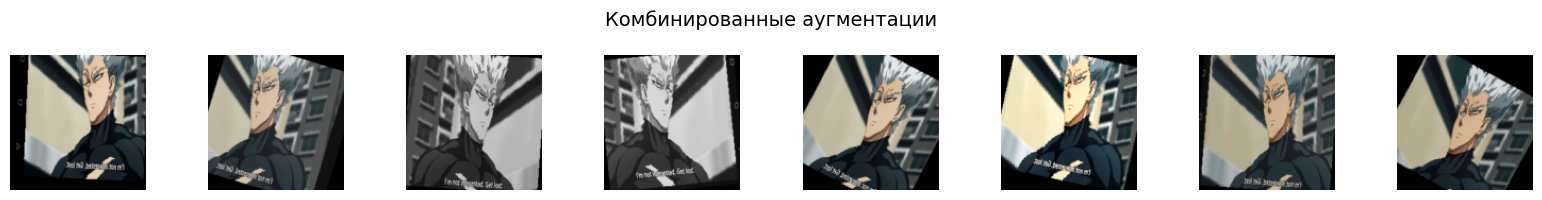

Оригинальное изображение, класс: Генос


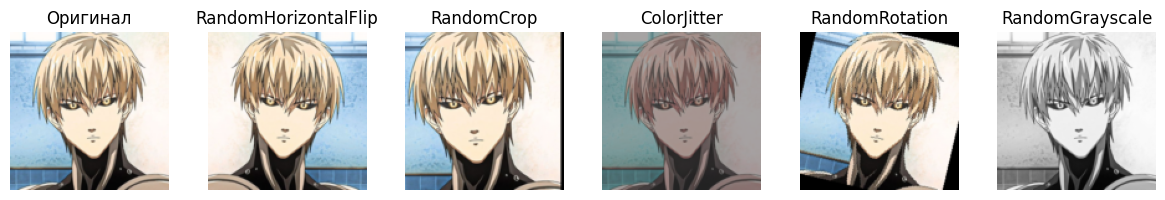

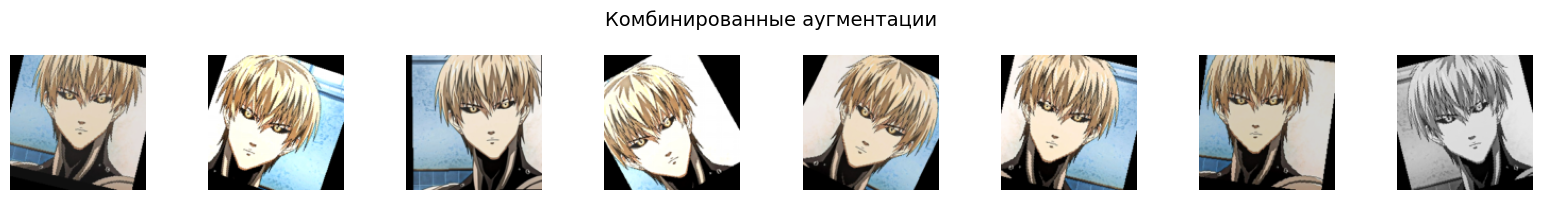

Оригинальное изображение, класс: Сайтама


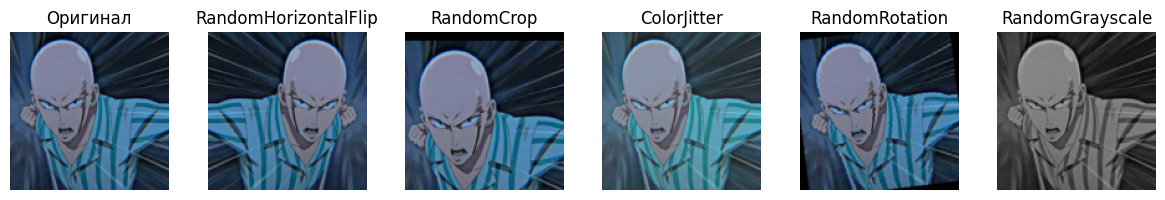

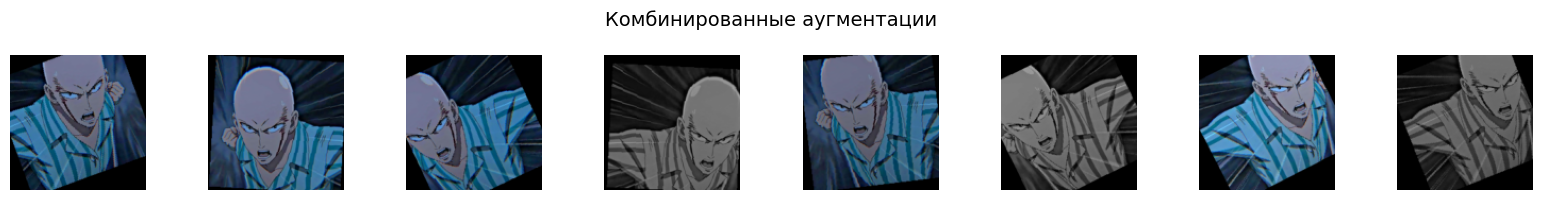

Оригинальное изображение, класс: Соник


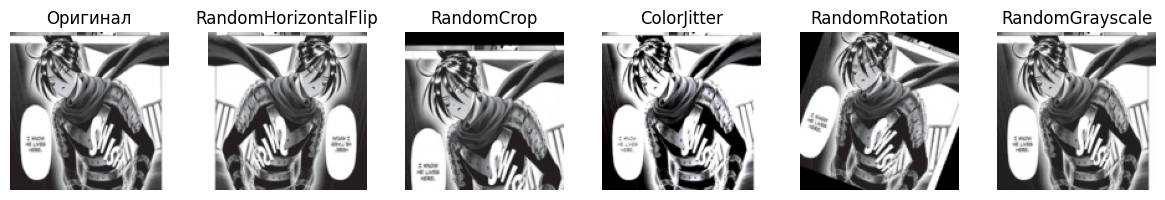

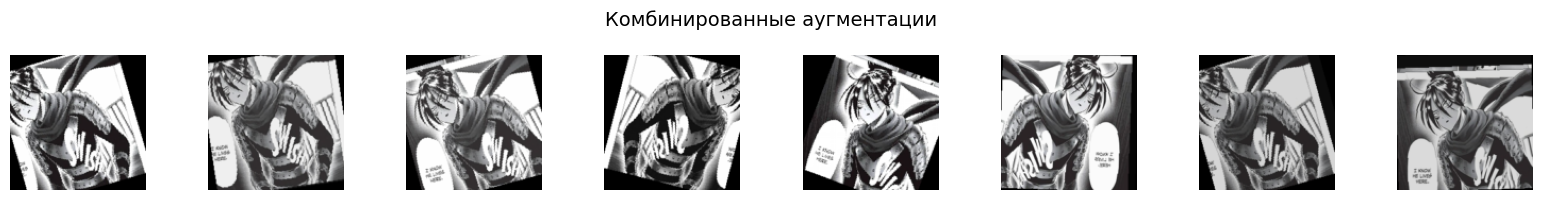

Оригинальное изображение, класс: Татсумаки


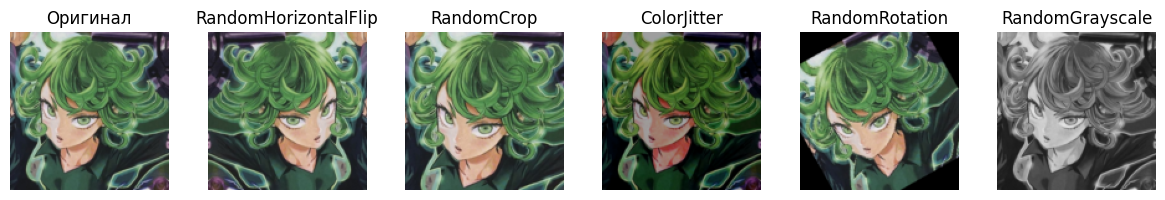

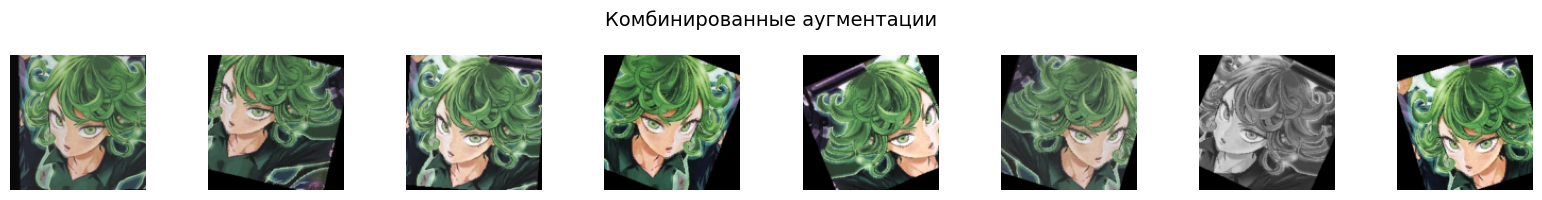

Оригинальное изображение, класс: Фубуки


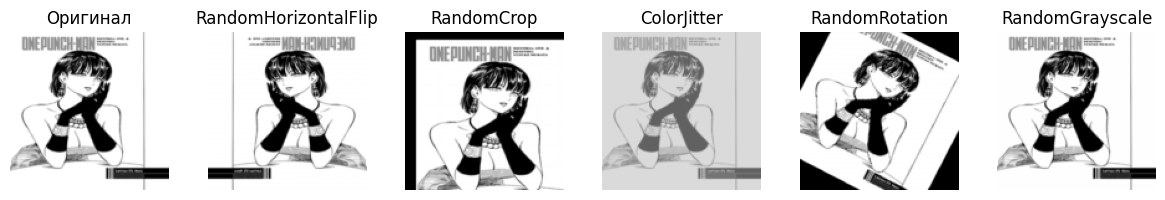

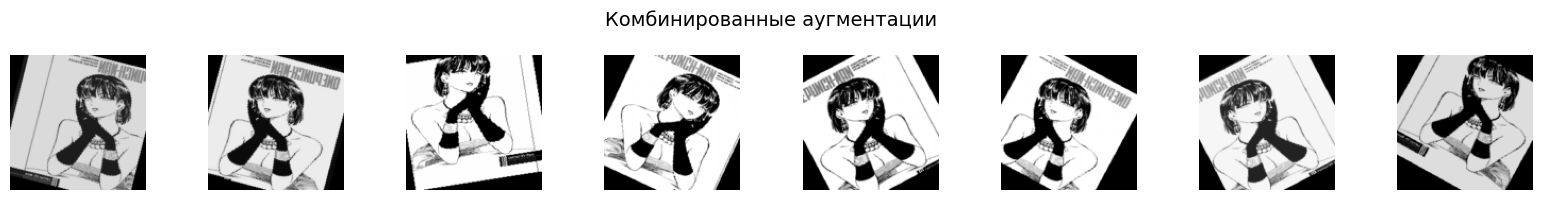

In [21]:
for i in range(len(class_names)):
  class_idx = dataset.labels.index(i)
  original_img, label = dataset[class_idx]
  print(f"Оригинальное изображение, класс: {class_names[i]}")

  augmented_imgs = []
  titles = []

  for name, aug in standard_augs:
      aug_img = aug(original_img)
      augmented_imgs.append(aug_img)
      titles.append(name)
  show_augmentations(original_img, augmented_imgs, titles)

  combined_imgs = []
  for i in range(8):
      combined_img = combined_aug(original_img)
      combined_imgs.append(combined_img)
  show_images(combined_imgs, title="Комбинированные аугментации")

# Задание 2: Кастомные аугментации

Оригинальное изображение, класс: Гароу


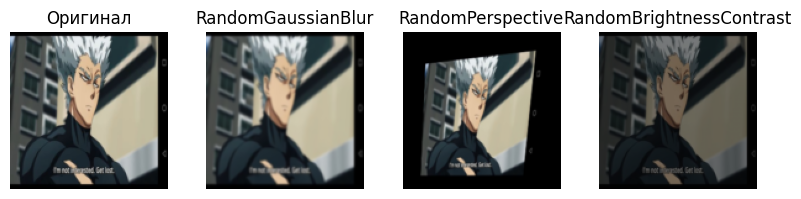

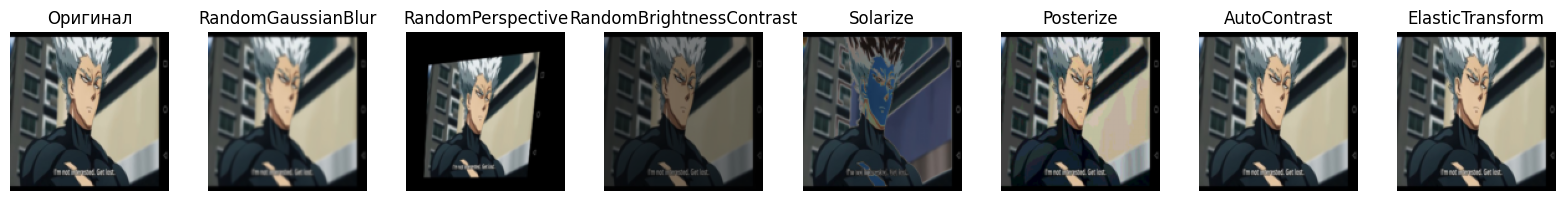

Оригинальное изображение, класс: Генос


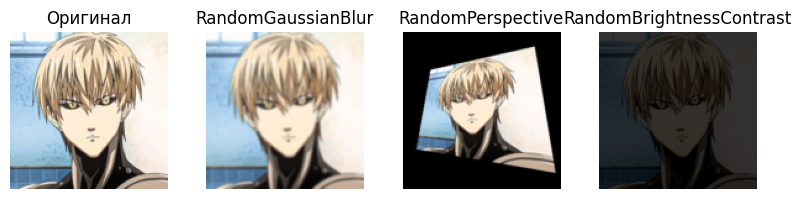

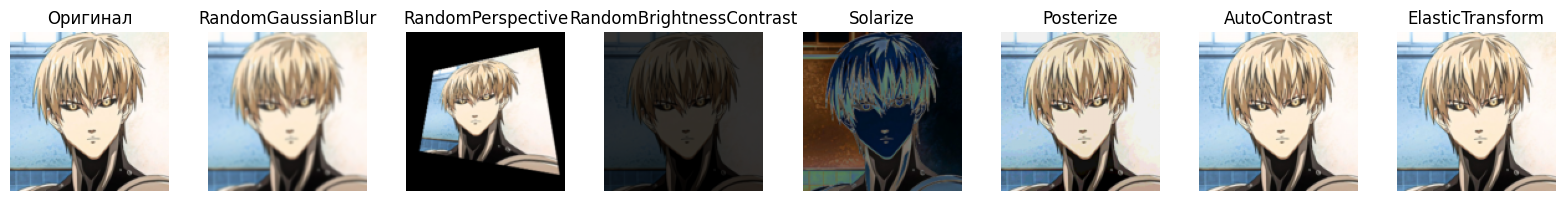

Оригинальное изображение, класс: Сайтама


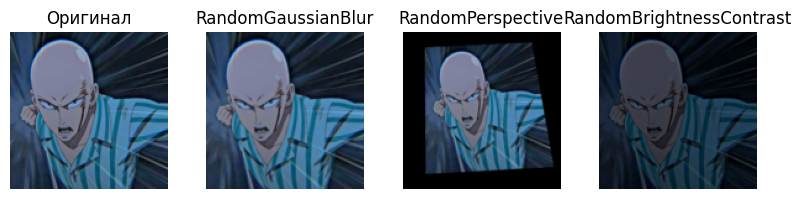

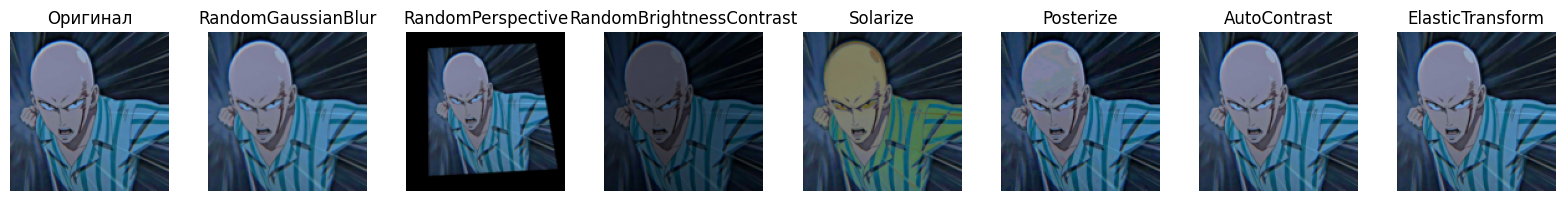

Оригинальное изображение, класс: Соник


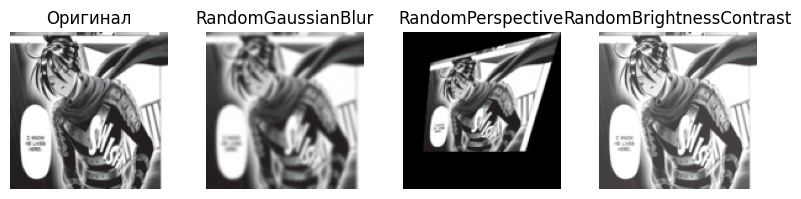

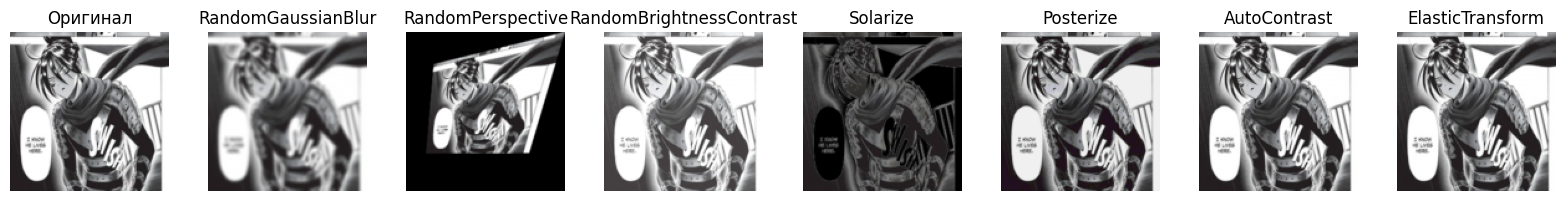

Оригинальное изображение, класс: Татсумаки


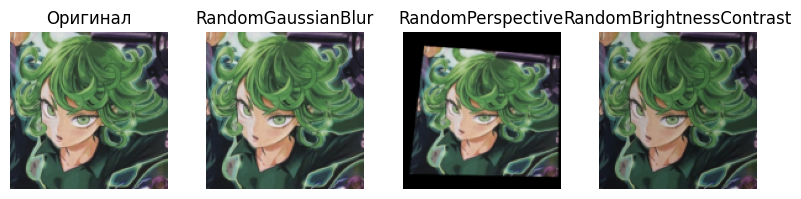

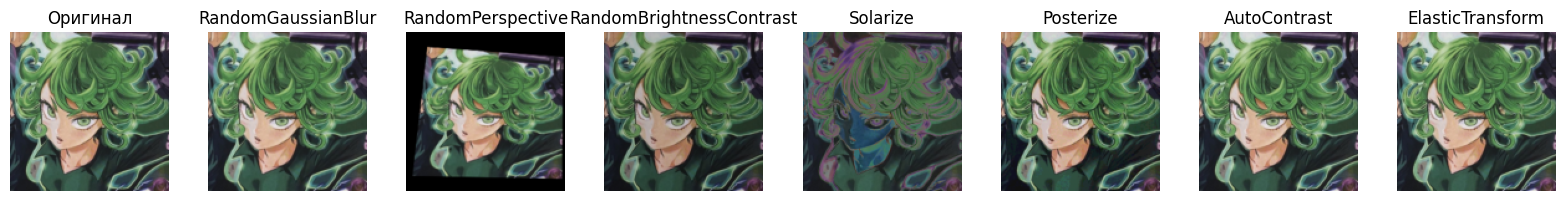

Оригинальное изображение, класс: Фубуки


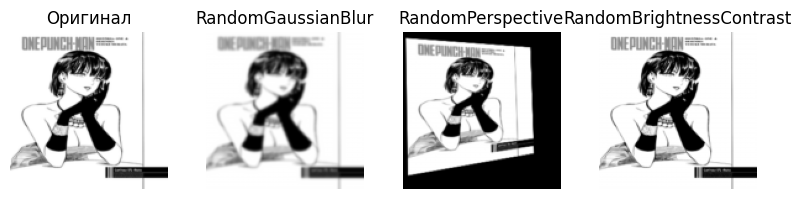

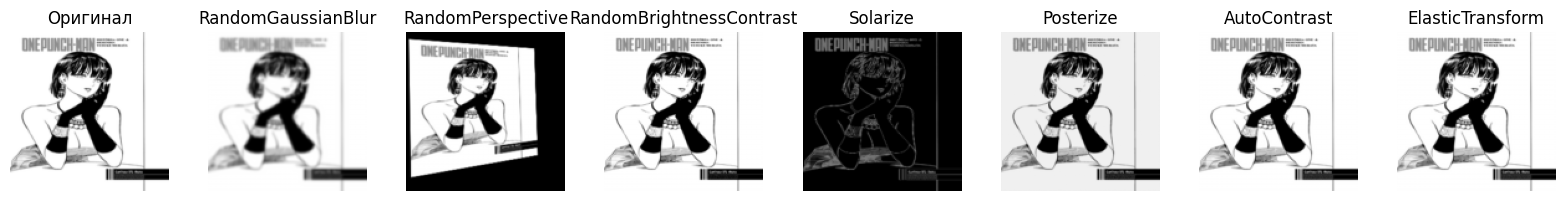

In [24]:
class RandomBrightnessContrast:
    """Меняет яркость и контрастность изображения на случайное значение"""
    def __init__(self):
      self.brightness = np.random.random()
      self.contrast = np.random.random()
    def __call__(self, img):
      aug = transforms.ColorJitter(self.brightness, self.contrast)
      aug_img = aug(img)
      return aug_img


custom_augs = [
        ('RandomGaussianBlur', transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel_size=9, sigma=(0.02, 2.0))])),
        ('RandomPerspective', transforms.Compose([transforms.ToTensor(), transforms.RandomPerspective(distortion_scale=0.5, p=1.0)])),
        ('RandomBrightnessContrast', transforms.Compose([transforms.ToTensor(), RandomBrightnessContrast()]))
    ]

extra_augs = [
        ('Solarize', transforms.Compose([transforms.ToTensor(), Solarize()])),
        ('Posterize', transforms.Compose([transforms.ToTensor(), Posterize()])),
        ('AutoContrast', transforms.Compose([transforms.ToTensor(), AutoContrast()])),
        ('ElasticTransform', transforms.Compose([transforms.ToTensor(), ElasticTransform()]))
    ]

for i in range(len(class_names)):
  class_idx = dataset.labels.index(i)
  original_img, label = dataset[class_idx]
  print(f"Оригинальное изображение, класс: {class_names[i]}")

  augmented_imgs = []
  titles = []

  for name, aug in custom_augs:
      aug_img = aug(original_img)
      augmented_imgs.append(aug_img)
      titles.append(name)
  show_augmentations(original_img, augmented_imgs, titles)

  for name, aug in extra_augs:
      aug_img = aug(original_img)
      augmented_imgs.append(aug_img)
      titles.append(name)
  show_augmentations(original_img, augmented_imgs, titles)

# Задание 3: Анализ датасета

In [ ]:
# Сбор статистики по изображениям
image_counts = {}
image_sizes = {}

all_widths = []
all_heights = []

train_dataset = CustomImageDataset(train_dir)
# test_dataset = CustomImageDataset(test_dir)
class_names = train_dataset.get_class_names()

for cls_idx in range(len(class_names)):
    sizes = []
    count = 0
    cls_start_idx = train_dataset.labels.index(cls_idx)
    for idx in range(cls_start_idx, len(train_dataset.images)):
        if train_dataset.labels[idx] == cls_start_idx + 1:
          break
        img_idx = train_dataset.images[idx]
        with Image.open(img_idx) as img:
          w, h = img.size
          sizes.append((w, h))
          all_widths.append(w)
          all_heights.append(h)
    image_counts[class_names[cls_idx]] = count
    image_sizes[class_names[cls_idx]] = sizes

min_sizes = {}
max_sizes = {}
mean_sizes = {}

for folder, sizes in image_sizes.items():
    if sizes:
        widths, heights = zip(*sizes)
        min_sizes[folder] = (min(widths), min(heights))
        max_sizes[folder] = (max(widths), max(heights))
        mean_sizes[folder] = (np.mean(widths), np.mean(heights))
    else:
        min_sizes[folder] = (0, 0)
        max_sizes[folder] = (0, 0)
        mean_sizes[folder] = (0, 0)

# Гистограмма количества изображений по классам
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='purple', alpha=0.7)
plt.title('Количество изображений в каждом классе')
plt.ylabel('Количество')
plt.xlabel('Класс')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'image_counts_histogram.png'))
plt.close()

# Диаграммы размеров по классам
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(min_sizes.keys(), [w for w, h in min_sizes.values()], color='blue', alpha=0.6, label='Min Width')
axes[0].bar(min_sizes.keys(), [h for w, h in min_sizes.values()], color='cyan', alpha=0.6, label='Min Height', bottom=[w for w, h in min_sizes.values()])
axes[0].set_title('Минимальные размеры (ширина + высота)')
axes[0].legend()

axes[1].bar(max_sizes.keys(), [w for w, h in max_sizes.values()], color='red', alpha=0.6, label='Max Width')
axes[1].bar(max_sizes.keys(), [h for w, h in max_sizes.values()], color='orange', alpha=0.6, label='Max Height', bottom=[w for w, h in max_sizes.values()])
axes[1].set_title('Максимальные размеры (ширина + высота)')
axes[1].legend()

axes[2].bar(mean_sizes.keys(), [w for w, h in mean_sizes.values()], color='green', alpha=0.6, label='Mean Width')
axes[2].bar(mean_sizes.keys(), [h for w, h in mean_sizes.values()], color='lime', alpha=0.6, label='Mean Height', bottom=[w for w, h in mean_sizes.values()])
axes[2].set_title('Средние размеры (ширина + высота)')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'image_sizes_distribution.png'))
plt.close()

# Гистограммы распределения всех размеров по всем изображениям
plt.figure(figsize=(12, 5))
plt.hist(all_widths, bins=20, alpha=0.7, label='Ширина')
plt.hist(all_heights, bins=20, alpha=0.7, label='Высота')
plt.title('Распределение ширины и высоты всех изображений')
plt.xlabel('Пиксели')
plt.ylabel('Количество изображений')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'all_image_sizes_hist.png'))
plt.close()

# --- Табличный вывод статистики ---
print('Класс\tКол-во\tМин. размер\tМакс. размер\tСредний размер')
for folder in class_names:
    print(f'{folder}\t{image_counts[folder]}\t{min_sizes[folder]}\t{max_sizes[folder]}\t{mean_sizes[folder]}')

# Задание 4: Pipeline аугментаций

In [ ]:
class AugmentationPipeline:
    """
    Класс для создания и управления пайплайном аугментаций изображений.
    """
    def __init__(self):
        self.augmentations = {}

    def add_augmentation(self, name, aug):
        self.augmentations[name] = aug

    def remove_augmentation(self, name):
        if name in self.augmentations:
            del self.augmentations[name]

    def apply(self, image):
        img = image
        for name, aug in self.augmentations.items():
            if isinstance(aug, transforms.RandomCrop):
                crop_size = aug.size if isinstance(aug.size, tuple) else (aug.size, aug.size)
                if img.size[0] < crop_size[0] or img.size[1] < crop_size[1]:
                    # Пропускаем эту аугментацию
                    continue
            img = aug(img)
        return img

    def get_augmentations(self):
        return list(self.augmentations.keys())

light_pipeline = AugmentationPipeline()
light_pipeline.add_augmentation('RandomHorizontalFlip', transforms.RandomHorizontalFlip(p=1.0))

medium_pipeline = AugmentationPipeline()
medium_pipeline.add_augmentation('RandomHorizontalFlip', transforms.RandomHorizontalFlip(p=1.0))
medium_pipeline.add_augmentation('RandomCrop', transforms.RandomCrop(200, padding=20))

heavy_pipeline = AugmentationPipeline()
heavy_pipeline.add_augmentation('RandomHorizontalFlip', transforms.RandomHorizontalFlip(p=1.0))
heavy_pipeline.add_augmentation('RandomCrop', transforms.RandomCrop(200, padding=20))
heavy_pipeline.add_augmentation('ColorJitter', transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1))
heavy_pipeline.add_augmentation('RandomRotation', transforms.RandomRotation(degrees=30))
heavy_pipeline.add_augmentation('RandomGrayscale', transforms.RandomGrayscale(p=0.5))

# Задание 6: Дообучение предобученных моделей

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


train_dataset = CustomImageDataset('data/train', transform=transform)
test_dataset = CustomImageDataset('data/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Загрузка предобученной модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.get_class_names()))
model = model.to(device)
num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = running_corrects / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Оценка на тесте
    model.eval()
    test_loss, test_corrects, test_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_corrects += (preds == labels).sum().item()
            test_total += labels.size(0)
    test_losses.append(test_loss / test_total)
    test_accs.append(test_corrects / test_total)

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss по эпохам')
plt.legend()
plt.savefig(os.path.join(results_dir, 'finetune_loss.png'))
plt.close()

plt.figure(figsize=(10,5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy по эпохам')
plt.legend()
plt.savefig(os.path.join(results_dir, 'finetune_accuracy.png'))
plt.close()